In [155]:

import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [8]:
import os
import gzip
import numpy as np

def load_mnist(path, kind='train'):
    """Load MNIST data from `path`"""
    labels_path = os.path.join(path, f'{kind}-labels-idx1-ubyte.gz')
    images_path = os.path.join(path, f'{kind}-images-idx3-ubyte.gz')

    with gzip.open(labels_path, 'rb') as lbpath:
        labels = np.frombuffer(lbpath.read(), dtype=np.uint8, offset=8)

    with gzip.open(images_path, 'rb') as imgpath:
        images = np.frombuffer(imgpath.read(), dtype=np.uint8, offset=16).reshape(len(labels), 784)

    return images, labels


In [10]:
# Replace 'path_to_your_data' with the actual path where the .gz files are located
train_images, train_labels = load_mnist('mnist-data', kind='train')
test_images, test_labels = load_mnist('mnist-data', kind='t10k')

# Optionally, reshape the images to 28x28 pixels for visualization or further processing
train_images = train_images.reshape(-1, 28, 28)
test_images = test_images.reshape(-1, 28, 28)


In [12]:
# training set
tr_imgs = train_images[:50000]
tr_labels = train_labels[:50000]

# validation set
val_imgs = train_images[50000:]
val_labels = train_labels[50000:]

# test set
te_imgs = test_images
te_labels = test_labels

tr_imgs.shape, tr_labels.shape, val_imgs.shape, val_labels.shape

### Visualization

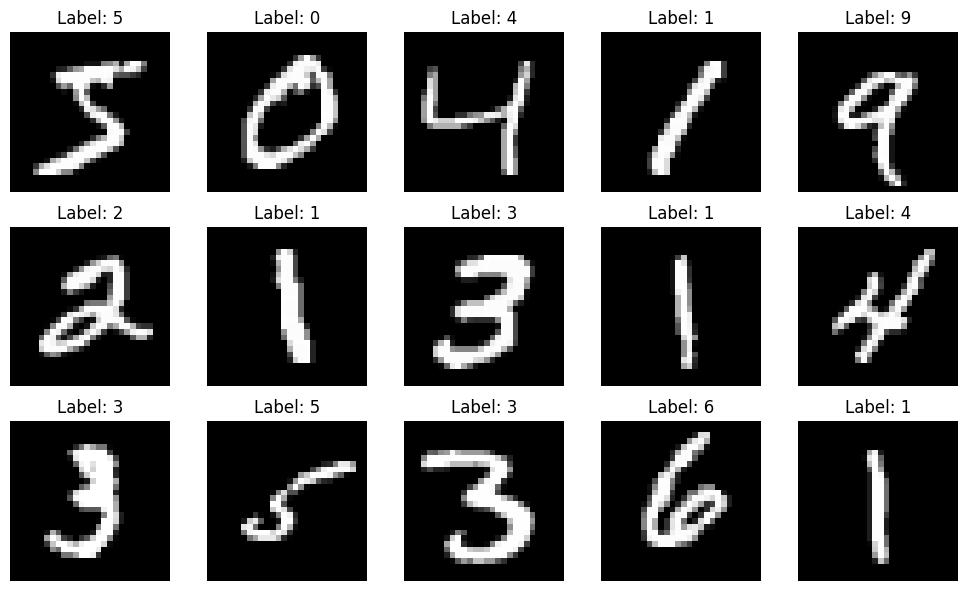

In [14]:
import matplotlib.pyplot as plt
%matplotlib inline

# Function to display a grid of images
def display_images(images, labels, nrows=3, ncols=5):
    plt.figure(figsize=(10, 6))
    for i in range(nrows * ncols):
        plt.subplot(nrows, ncols, i + 1)
        plt.imshow(images[i], cmap='gray')
        plt.title(f'Label: {labels[i]}')
        plt.axis('off')
    plt.tight_layout()
    plt.show()

# Displaying images from the training set
display_images(tr_imgs, tr_labels)


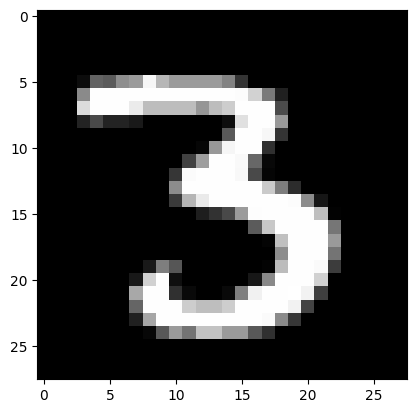

In [30]:
# import torch
# plt.imshow(torch.tensor(tr_imgs[12]), cmap='gray')
plt.imshow(tr_imgs[12], cmap='gray')

In [27]:
tr_imgs[12].shape   # a 28x28 pixel image of digit 3

(28, 28)

In [40]:
tr_imgs_norm = tr_imgs/255
# plt.imshow(tr_imgs_norm[0], cmap='gray')
tr_imgs_norm[0].shape

(28, 28)

In [ ]:
def relu(x):
    return torch.max(torch.zeros_like(x), x)

In [28]:
# -------- model --------------------

In [51]:
import torch
Xtr, Ytr = torch.tensor(tr_imgs, dtype=torch.float32), torch.tensor(tr_labels, dtype=torch.float32)
Xdev, Ydev = torch.tensor(val_imgs, dtype=torch.float32), torch.tensor(val_labels, dtype=torch.float32)
Xte, Yte = torch.tensor(te_imgs, dtype=torch.float32), torch.tensor(te_labels, dtype=torch.float32)

Xtr.shape, Ytr.shape

(torch.Size([50000, 28, 28]), torch.Size([50000]))

In [216]:
# initialization
input_size = 28*28
output_size = 10
hidden_size = 128   # 64 => 82%  |||||||||| # 128 => 85%

g = torch.Generator().manual_seed(2147483647) # for reproducibility
W1 = torch.randn((input_size, hidden_size),   generator=g) * 0.1
b1 = torch.randn(hidden_size,                 generator=g) * 0.02
W2 = torch.randn((hidden_size, output_size),  generator=g) * 0.01
b2 = torch.randn(output_size,                 generator=g) * 0

parameters = [W1, b1, W2, b2]
print(sum(p.nelement() for p in parameters))  # no. of parameters in total
for p in parameters:
    p.requires_grad = True

101770


In [42]:
ix = torch.randint(0, Xtr.shape[0], (32,), generator=g)
Xb, Yb = Xtr[ix], Ytr[ix] 
Xb.shape, Yb.shape, Xb.view(-1, 28*28).shape

(torch.Size([32, 28, 28]), torch.Size([32]), torch.Size([32, 784]))

In [55]:
def relu(x):
    return torch.max(torch.zeros_like(x), x)

def softmax(x):
    exp_x = torch.exp(x - torch.max(x))
    return exp_x / torch.sum(exp_x, 1, keepdims=True)

In [217]:
batch_size = 32
max_steps = 200000

for i in range(max_steps):
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix]   # batch X, Y
    
    # forward pass
    z1 = ((Xb.view(-1, 784) + 1)/255) @ W1 + b1   # 32, 28*28 || 784, 64
    a1 = torch.sigmoid(z1)
    z2 = a1 @ W2 + b2      # 32, 64 || 64, 10 
    pred = softmax(z2)
    # print(pred.dtype, Yb.dtype)
    
    # loss
    loss = F.cross_entropy(pred, Yb.long())
    
    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
    
    # update 
    lr = 0.1 if i < 100000 else 0.01
    for p in parameters:
        p.data += -lr * p.grad
    
    if i % 10000 == 0:
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
        
    # break;

      0/ 200000: 2.3019
  10000/ 200000: 1.6198
  20000/ 200000: 1.6789
  30000/ 200000: 1.6909
  40000/ 200000: 1.5846
  50000/ 200000: 1.4967
  60000/ 200000: 1.5796
  70000/ 200000: 1.5095
  80000/ 200000: 1.4695
  90000/ 200000: 1.4728
 100000/ 200000: 1.4835
 110000/ 200000: 1.5343
 120000/ 200000: 1.4922
 130000/ 200000: 1.5107
 140000/ 200000: 1.4934
 150000/ 200000: 1.4645
 160000/ 200000: 1.4759
 170000/ 200000: 1.4862
 180000/ 200000: 1.5045
 190000/ 200000: 1.5073


In [218]:
# Ensure no gradients are computed for this operation
with torch.no_grad():
    # Forward pass for the test set
    z1_test = ((Xte.view(-1, 784) + 1)/255) @ W1 + b1
    a1_test = torch.sigmoid(z1_test)
    z2_test = a1_test @ W2 + b2
    pred_test = softmax(z2_test)  # You can use the same softmax function as before

    # Compute the loss on the test set
    test_loss = F.cross_entropy(pred_test, Yte.long())

print(f'Test Loss: {test_loss.item():.4f}')


Test Loss: 1.5081


In [219]:
# Ensure no gradients are computed for this part
with torch.no_grad():
    # Forward pass for the test set
    z1_test = ((Xte.view(-1, 784) + 1)/255) @ W1 + b1
    a1_test = torch.sigmoid(z1_test)
    z2_test = a1_test @ W2 + b2
    pred_test = softmax(z2_test)

    # Get the predicted labels by finding the index of the max log-probability
    pred_labels = torch.argmax(pred_test, dim=1)

    # Compare with true labels to find where predictions are correct
    correct_preds = (pred_labels == Yte.long()).float()  # Convert to float to allow mean calculation
    num_correct = correct_preds.sum().item()  # Total number of correct predictions
    num_samples = Yte.size(0)  # Total number of samples

    # Calculate the accuracy as percentage
    accuracy = 100.0 * num_correct / num_samples

print(f'Correct Predictions: {num_correct}/{num_samples}')
print(f'Accuracy: {accuracy:.2f}%')


Correct Predictions: 9571.0/10000
Accuracy: 95.71%


In [220]:
z1 = ((Xb.view(-1, 784) + 1)/255) @ W1 + b1   # 32, 28*28 || 784, 64
a1 = torch.sigmoid(z1)
z2 = a1 @ W2 + b2      # 32, 64 || 64, 10 
pred = softmax(z2)
z1.shape, a1.shape, z2.shape, pred.shape

(torch.Size([32, 128]),
 torch.Size([32, 128]),
 torch.Size([32, 10]),
 torch.Size([32, 10]))

tensor(0.3762, grad_fn=<StdBackward0>)

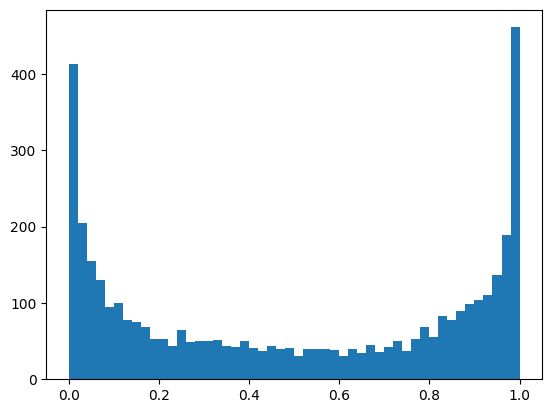

In [228]:
# z1[0]
plt.hist(a1.view(-1).tolist(), 50)
a1.view(-1).std()

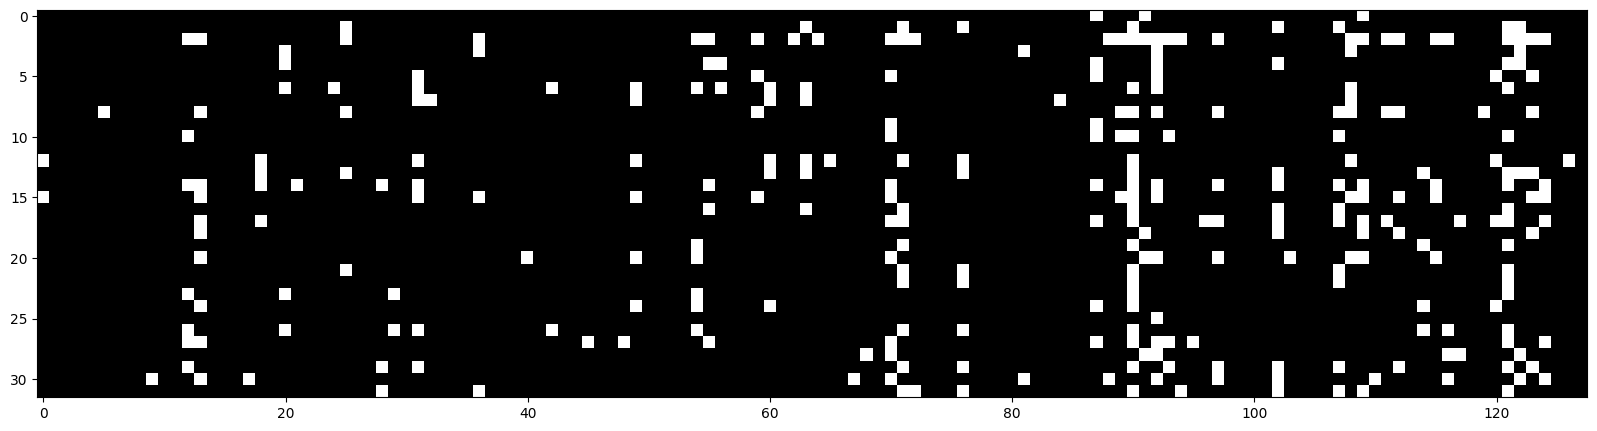

In [229]:
plt.figure(figsize=(20,10))
plt.imshow(a1.abs() > 0.99, cmap='gray', interpolation='nearest')

In [147]:
z1 = ((Xb.view(-1, 784)+1)/255) @ W1 + b1
# a1_exp = torch.exp(z1 - torch.max(z1))
z2 = z1 @ W2 + b2      # 32, 64 || 64, 10 
a1 = torch.sigmoid(z2)
a1[0]

tensor([0.5159, 0.5119, 0.4664, 0.5261, 0.4897, 0.5010, 0.4651, 0.4911, 0.5421,
        0.5229], grad_fn=<SelectBackward0>)

In [149]:
pred = torch.max(a1)
pred

tensor(0.5421, grad_fn=<MaxBackward1>)

(array([ 1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  1.,  1.,  0.,  1.,
         2.,  0.,  2.,  2.,  4.,  5.,  5., 11., 11.,  9., 14.,  6., 10.,
         5., 18., 16., 27., 14., 24., 18., 11., 19., 10., 14., 22.,  7.,
         8.,  4.,  5.,  2.,  5.,  2.,  0.,  0.,  1.,  1.,  1.]),
 array([-0.2949152 , -0.28564281, -0.27637042, -0.26709803, -0.25782564,
        -0.24855325, -0.23928086, -0.23000847, -0.22073608, -0.21146369,
        -0.20219131, -0.19291892, -0.18364653, -0.17437414, -0.16510175,
        -0.15582936, -0.14655697, -0.13728458, -0.12801219, -0.1187398 ,
        -0.10946741, -0.10019502, -0.09092263, -0.08165024, -0.07237785,
        -0.06310546, -0.05383307, -0.04456069, -0.0352883 , -0.02601591,
        -0.01674352, -0.00747113,  0.00180126,  0.01107365,  0.02034604,
         0.02961843,  0.03889082,  0.04816321,  0.0574356 ,  0.06670799,
         0.07598038,  0.08525277,  0.09452516,  0.10379755,  0.11306993,
         0.12234232,  0.13161471,  0.1408871 ,  0.15015949,

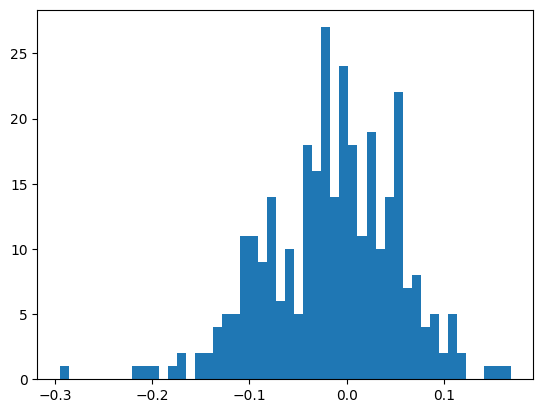

In [144]:
b = (Xb+1)/255
plt.hist(z2.view(-1).tolist(), 50)

In [88]:
z1[0]

tensor([ 25.5989,  21.6468,  -4.1939,   5.6210,  17.5528,   2.0654,   3.1753,
         14.9516, -18.2015,   9.2614, -17.9496, -10.8421,  -1.8105,  10.7536,
         21.5948,  11.7649,   6.0579,  23.5393,  21.2012,   6.3211,  15.9572,
         -5.6269,  13.6366,   4.8338,   5.3918, -38.8676,  16.9534,  15.1389,
          8.0964,  -5.2771,  15.9930,  -7.0513,  -0.1584,  -7.6395,  -5.6891,
          9.7984, -22.0101, -12.7311,  -1.3831,  -2.2139,  -4.0594,   8.4991,
        -12.0253,  13.7039, -13.5119,   5.4747,  15.7053,  -8.5521,   3.1928,
         -8.6281,  13.6652,   5.9675,   1.6680,   8.0886,  25.5124, -17.7177,
         -6.2602,  -8.5279, -12.9297, -17.6497,   4.1782,  -6.1606,   4.0039,
         -2.3258], grad_fn=<SelectBackward0>)

### Using Adam optimizer

In [230]:
import torch.optim as optim

# Define your parameters (weights and biases) as a list
parameters = [W1, b1, W2, b2]

# Create an AdamW optimizer instance
optimizer = optim.AdamW(parameters, lr=1e-3)  # You can adjust the learning rate and other hyperparameters as needed

batch_size = 32
max_steps = 200000

for i in range(max_steps):
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix]   # Select a batch

    # Forward pass
    z1 = ((Xb.view(-1, 784) + 1)/255) @ W1 + b1
    a1 = torch.sigmoid(z1)
    z2 = a1 @ W2 + b2
    pred = softmax(z2)

    # Compute the loss
    loss = F.cross_entropy(pred, Yb.long())

    # Zero the gradients before the backward pass
    optimizer.zero_grad()

    # Backward pass
    loss.backward()

    # Update the parameters using AdamW
    optimizer.step()

    # Adjust the learning rate if needed
    if i == 100000:
        for param_group in optimizer.param_groups:
            param_group['lr'] = 0.01

    if i % 10000 == 0:
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')


      0/ 200000: 1.5655
  10000/ 200000: 1.4853
  20000/ 200000: 1.4621
  30000/ 200000: 1.4617
  40000/ 200000: 1.4618
  50000/ 200000: 1.4668
  60000/ 200000: 1.4613
  70000/ 200000: 1.4651
  80000/ 200000: 1.4614
  90000/ 200000: 1.4612
 100000/ 200000: 1.4614
 110000/ 200000: 1.4909
 120000/ 200000: 1.4614
 130000/ 200000: 1.4616
 140000/ 200000: 1.4708
 150000/ 200000: 1.4839
 160000/ 200000: 1.5104
 170000/ 200000: 1.4765
 180000/ 200000: 1.4618
 190000/ 200000: 1.4616


In [231]:
# Ensure no gradients are computed for this operation
with torch.no_grad():
    # Forward pass for the test set
    z1_test = ((Xte.view(-1, 784) + 1)/255) @ W1 + b1
    a1_test = torch.sigmoid(z1_test)
    z2_test = a1_test @ W2 + b2
    pred_test = softmax(z2_test)  # You can use the same softmax function as before

    # Compute the loss on the test set
    test_loss = F.cross_entropy(pred_test, Yte.long())

print(f'Test Loss: {test_loss.item():.4f}')


Test Loss: 1.4977


In [232]:
# Ensure no gradients are computed for this part
with torch.no_grad():
    # Forward pass for the test set
    z1_test = ((Xte.view(-1, 784) + 1)/255) @ W1 + b1
    a1_test = torch.sigmoid(z1_test)
    z2_test = a1_test @ W2 + b2
    pred_test = softmax(z2_test)

    # Get the predicted labels by finding the index of the max log-probability
    pred_labels = torch.argmax(pred_test, dim=1)

    # Compare with true labels to find where predictions are correct
    correct_preds = (pred_labels == Yte.long()).float()  # Convert to float to allow mean calculation
    num_correct = correct_preds.sum().item()  # Total number of correct predictions
    num_samples = Yte.size(0)  # Total number of samples

    # Calculate the accuracy as percentage
    accuracy = 100.0 * num_correct / num_samples

print(f'Correct Predictions: {num_correct}/{num_samples}')
print(f'Accuracy: {accuracy:.2f}%')


Correct Predictions: 9655.0/10000
Accuracy: 96.55%
